In [23]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Load the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images to a range of 0 to 1
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

In [24]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


"""model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])"""

"""model = models.Sequential()

# Add CNN layer(s) to the model
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D())

# Add a flatten layer
model.add(layers.Flatten())

# Add Dense layer(s) to the model
model.add(layers.Dense(32, activation='relu'))

# The final layer needs to be a softmax
model.add(layers.Dense(10, activation='softmax'))"""

CNN_model = Sequential([
    # Input layer is implicitly defined by the input shape of the first Conv2D layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

CNN_model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9473 - loss: 0.1320
Epoch 2/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9498 - loss: 0.1295
Epoch 3/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9506 - loss: 0.1280
Epoch 4/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9528 - loss: 0.1203
Epoch 5/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9528 - loss: 0.1221
Epoch 6/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9540 - loss: 0.1166
Epoch 7/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9556 - loss: 0.1131
Epoch 8/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9572 - loss: 0.1099
Epoch 9/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9564 - loss: 0.1093
Epoch 10/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9589 - loss: 0.1059
Epoch 11/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9561 - loss: 0.1115
Epoch 12/40
1875/18

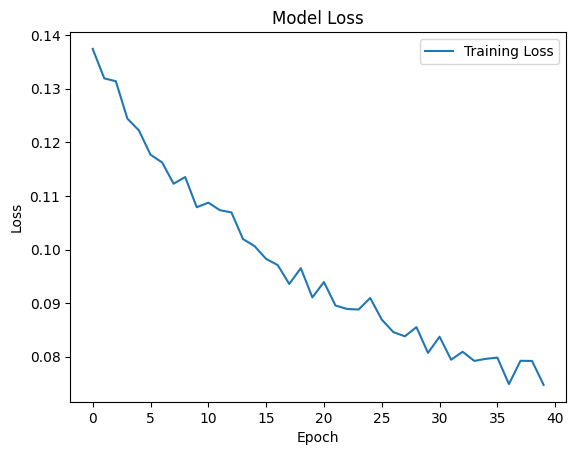

In [29]:
history = CNN_model.fit(train_images, train_labels, epochs=40, batch_size=32)

import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [26]:
test_loss, test_acc = CNN_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9105 - loss: 0.3260
Test accuracy: 0.9140999913215637


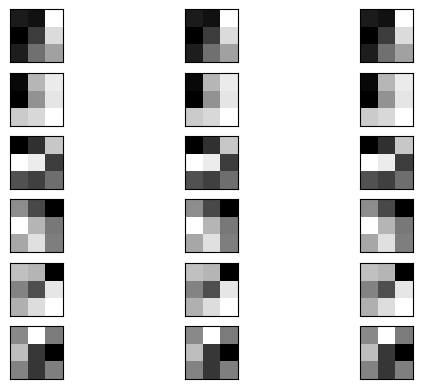

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Extract filters and biases from the first Conv2D layer
filters, biases = CNN_model.layers[0].get_weights()

# Normalize filter values to 0-1 so they can be plotted
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, 0], cmap='gray')
        ix += 1
# show the figure
plt.show()


In [28]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

test_image = np.random.random((28, 28))  # Assuming you have a test image of shape (28, 28)

# Reshape the test image to (1, 28, 28, 1)
test_image = test_image.reshape(1, 28, 28, 1)

# Call the model with the reshaped input to establish the input shape
CNN_model(test_image)

# Select the output of the layers you want to visualize
layer_outputs = [layer.output for layer in CNN_model.layers[:4]] # Visualize first four layers

# Create a model that will return these outputs, given the model input
activation_model = Model(inputs=CNN_model.input, outputs=layer_outputs)

# Use a test image
test_image = np.random.random((1, 28, 28, 1)) # Use your actual test image here

# Get the activations
activations = activation_model.predict(test_image)

# Plot the activations for the first Conv2D layer
first_layer_activation = activations[0]
num_filters = first_layer_activation.shape[-1]

fig, axes = plt.subplots(1, num_filters, figsize=(20, 20))
for i in range(num_filters):
    ax = axes[i]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.show()

ValueError: The layer sequential_2 has never been called and thus has no defined input.